In [61]:
from pymongo import MongoClient
import json
from scipy.spatial.distance import euclidean, pdist, squareform
import pandas as pd
import seaborn as sns

In [79]:
sns.set(rc={'figure.figsize':(20, 20)})

In [5]:
def similarity_func(u, v):
    return 1/(1+euclidean(u, v))

In [68]:
cfg = json.load(open('config/mongo.json'))

db = 'mongodb://{host}:{port}'.format(**cfg['local'])  # local DB
with MongoClient(db) as client:
    tracksDB = client[cfg['local']['database']]['tracks']
    artistsDB = client[cfg['local']['database']]['artists']

In [103]:
tracks_list = []

for track in tracksDB.find():
    tracks_list.append(track)
    
tracksDF = pd.DataFrame(tracks_list)
tracksDF['index'] = tracksDF['artist'] + '.' + tracksDF['name']
tracksDF.set_index('index', inplace=True)

In [112]:
attributes = ['acousticness',  'danceability', 'energy',  'instrumentalness', 'key',
              'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'mode', 'time_signature']

In [125]:
tracksDF[attributes].dropna()

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,mode,time_signature
index,,,,,,,,,,,,
The Weeknd.Call Out My Name,0.21100,0.449,0.599,0.000000,1.0,0.3270,-4.892,0.0369,134.144,0.1650,1.0,3.0
The Weeknd.Wasted Times,0.62200,0.562,0.674,0.000020,10.0,0.1110,-6.049,0.0851,122.699,0.2930,0.0,4.0
The Weeknd.Try Me,0.62200,0.466,0.672,0.001080,8.0,0.1470,-5.777,0.0680,91.673,0.1080,0.0,4.0
The Weeknd.Hurt You,0.30000,0.484,0.716,0.002140,5.0,0.1120,-7.193,0.1670,184.131,0.3650,0.0,4.0
The Weeknd.Pray For Me (with Kendrick Lamar),0.08050,0.728,0.668,0.000015,2.0,0.1020,-5.020,0.1260,100.537,0.1620,1.0,4.0
The Weeknd.I Was Never There,0.13500,0.324,0.735,0.000048,10.0,0.1690,-4.054,0.0337,113.923,0.1690,1.0,4.0
The Weeknd.Privilege,0.91300,0.391,0.595,0.005570,11.0,0.1450,-7.094,0.0411,93.780,0.3790,0.0,4.0
The Weeknd.Starboy,0.16500,0.681,0.594,0.000003,7.0,0.1340,-7.028,0.2820,186.054,0.5350,1.0,4.0
The Weeknd.I Feel It Coming,0.42900,0.769,0.813,0.000000,0.0,0.0952,-5.900,0.1430,92.985,0.5670,0.0,4.0


In [115]:
dists = pdist(tracksDF[attributes].dropna(), similarity_func)
df_euclid = pd.DataFrame(squareform(dists), columns=tracksDF[attributes].dropna().index, 
                         index=tracksDF[attributes].dropna().index)

In [116]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)

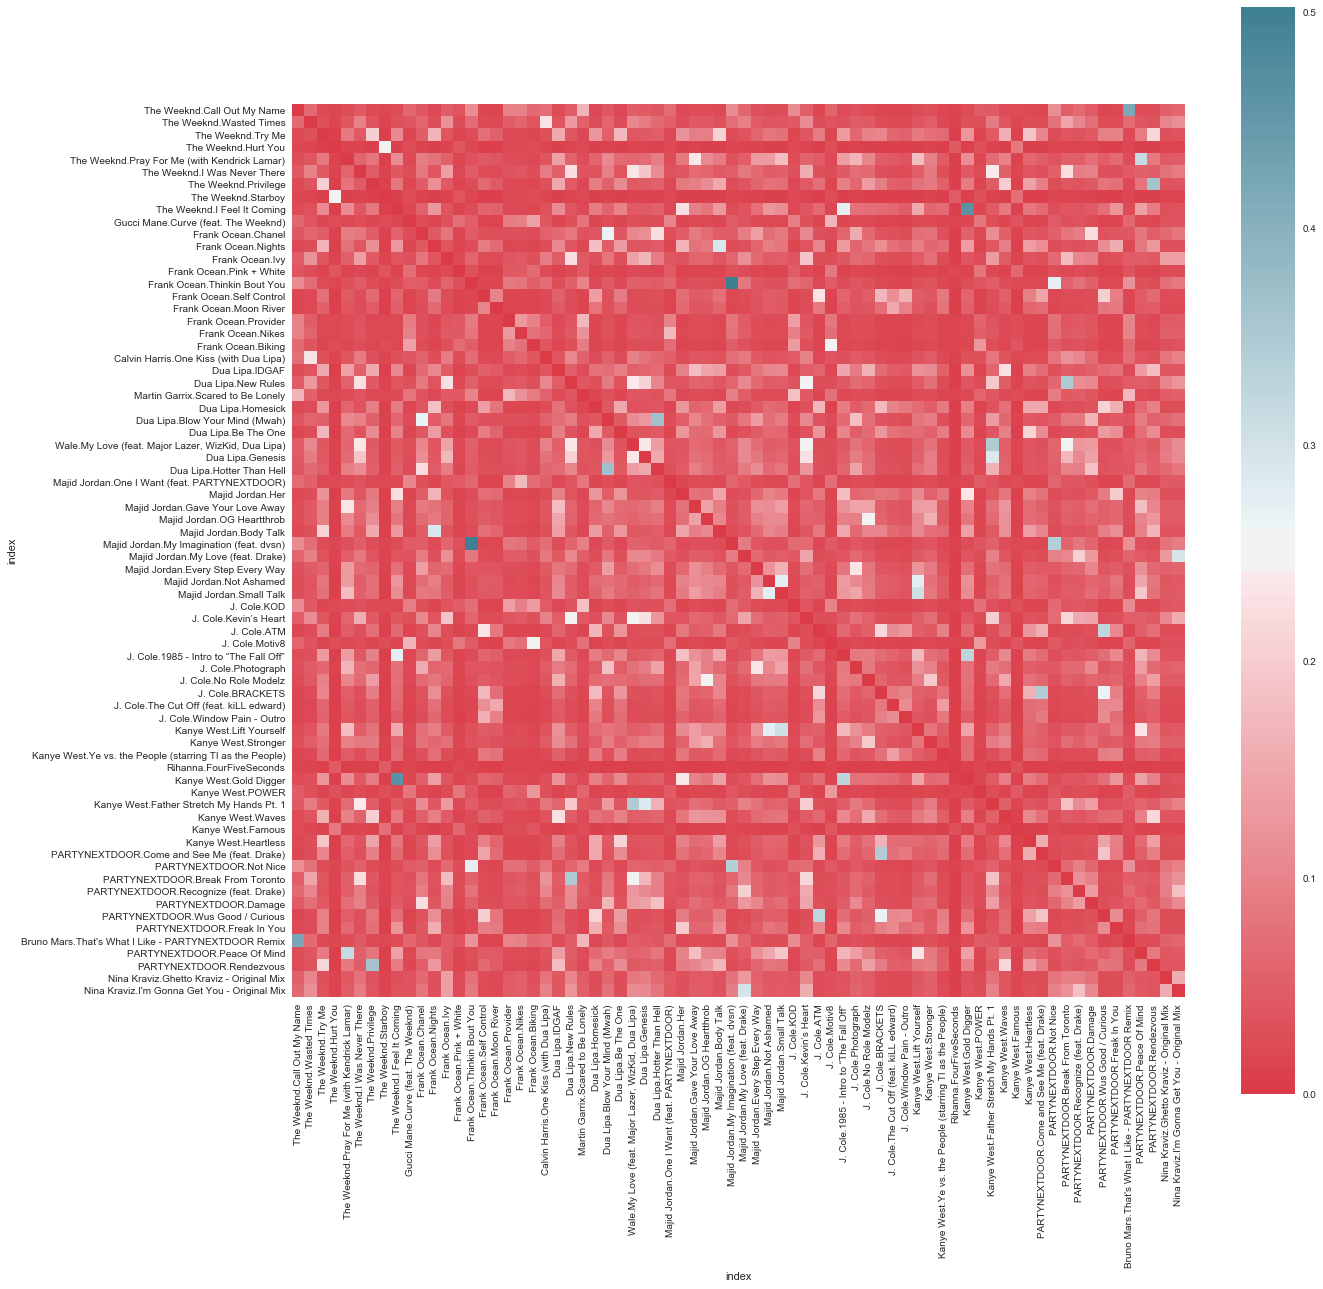

In [117]:
sns.heatmap(df_euclid, cmap=cmap, square=True)